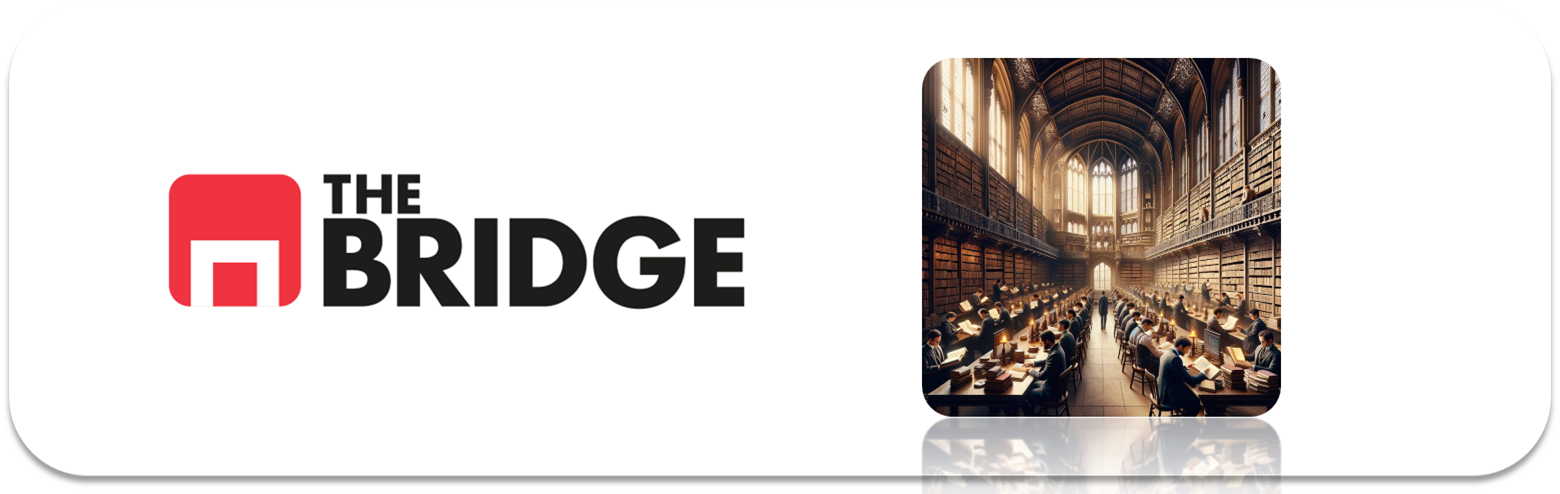

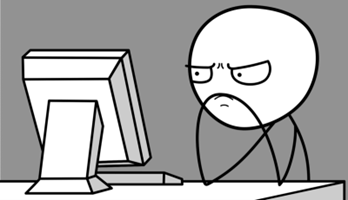

Para ejercitarte y afianzar lo aprendido sobre **NLP**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

## Twitter (now X) Sentiment Analysis
En este notebook vas a realizar un análisis de sentimientos sencillo sobre Tweets.

Estos programas son muy útiles en campañas de marketing, para monitorizar el lanzamiento de un nuevo producto, realizar seguimiento en Twitter de eventos, o simplemente tener monitorizadas ciertas cuentas o hashtags para tener un programa de análisis real time.

### Importa los datos

NOTA: Puedes descargártelos tal y como se muestra en la figura o bien emplear el fichero que hay en "data"

Vamos a utilizar un corpus de la [página del TASS](http://tass.sepln.org/tass_data/download.php), que se trata de una asociación de análisis semántico que encargada de recopilar texto y mantenerlo etiquetado.

![imagen](img/tass_register.png)

En este notebook se va a elegir un corpus genérico con no demasiados registros para aligerar la limpieza y entrenamiento de los modelos.

![imagen](img/download_train_spanish.png)

Lo ideal será siempre utilizar un corpus que sea afín a la temática que deseas predecir, por ejemplo si quieres monitorizar campañas de marketing, utiizar un corpus de texto que contenga comentarios acerca de la recepción a un determinado producto.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.stem.snowball import SnowballStemmer

### Ejercicio 1

Lee el dataset y conviértelo a un dataframe. Tendrás que recordar lo visto cuando procesamos ficheros XML, inténtalo sin ver la solución :-)

In [2]:
# La data proviene de un XML, por lo que se debe parsear
tree = ET.parse('data/general-train-tagged.xml')
root = tree.getroot()

In [3]:
# Vamos a crear un dataframe con los datos del xml
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)


(7219, 6)


### Ejercicio 2

Echa un vistazo al dataset. ¿Cuál crees que podría ser el target?

In [4]:
df.head()

,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P+,AGREEMENT


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7219 entries, 0 to 7218
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User      7219 non-null   object
 1   Content   7218 non-null   object
 2   Date      7219 non-null   object
 3   Lang      7219 non-null   object
 4   Polarity  7219 non-null   object
 5   Type      7219 non-null   object
dtypes: object(6)
memory usage: 338.5+ KB


*Solo hay un nulo en Content que luego veremos que coincide con el unico tuit que no está en español, lógicamente*

In [6]:
df.Lang.value_counts(True)

Lang
es         0.999861
unknown    0.000139
Name: proportion, dtype: float64

In [7]:
df[df.Lang != "es"]

,User,Content,Date,Lang,Polarity,Type
6055,Fgarea,None,2012-03-19T00:14:51,unknown,NONE,AGREEMENT


*Lang es una columna que puedo obviar y la fecha la podría pasar quizás a día de la semana o a varias columnas dia de la semana, mes, año (por ejemplo pensando que los sábados alguien puede estar más por la labor de ser positivo, o en Navidad igual hay más polaridad...), pero de primeras también la obviaremos*

*Podrían ser tanto "Polarity" como "Type". Nos vamos a quedar con Polarity (que es lo que normalmente asimilaremos a sentimiento)*

### Ejercicio 3

Existe una columna de polaridad que será la que empleemos como target. Por simplicidad, queremos predecir simplemente si son comentarios positivos o negativos. Transforma el target en dos clases agrupando, ¿Qué deberíamos hacer con los comentarios neutrales o sin polaridad?

In [8]:
# Vemos los valores unicos de la columna de polaridad
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

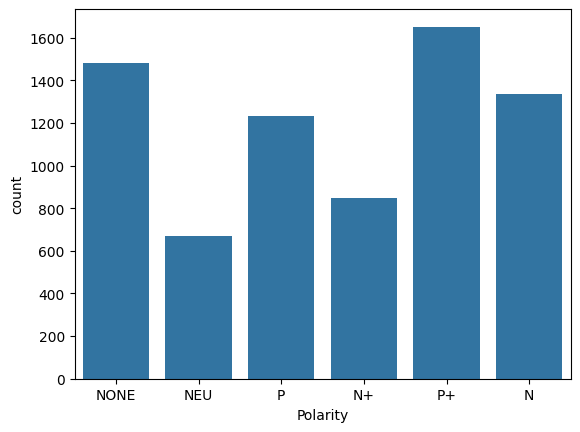

In [9]:
sns.countplot(x = 'Polarity', data=df);

*Queremos predecir si son comentarios positivos o negativos por lo que procedemos a agrupar comentarios, agregando las polaridades P (positivas) y P+ (muy positivas) a un grupo y las polaridades N (negativas) y N+ (muy negativas) a otro. ¿Qué hacemos con los comentarios neutrales? Probablemente no nos den mucha información predictiva así que prescindimos de ellos.*

In [10]:
# Funcion para convertir la polaridad a un valor numerico, positivas a 1 y negativas a 0
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 1
    elif x in ('N', 'N+'):
        return 0

In [11]:
# Nos cargamos los NONE y los neutros
df = df[~df['Polarity'].isin(['NONE', 'NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [12]:
# Pasamos la columna a 1s y 0s. Y el tipo
df['Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

array([1, 0], dtype=int64)

In [13]:
df.head(20)

,User,Content,Date,Lang,Polarity,Type
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,1,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,0,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,1,AGREEMENT
6,Carlos_Latre,Toca @crackoviadeTV3 . Grabación dl especial N...,2011-12-02T07:00:50,es,1,AGREEMENT
8,nacho_uriarte,Buen día todos! Lo primero mandar un abrazo gr...,2011-12-02T07:45:05,es,1,AGREEMENT
9,JuanraLucas,Desde el escaño. Todo listo para empezar #endi...,2011-12-02T07:54:19,es,1,AGREEMENT
10,pedroj_ramirez,Bdías. EM no se ira de puente. Si vosotros os ...,2011-12-02T07:58:02,es,1,AGREEMENT
11,sevillajordi,Un sistema económico q recorta dinero para pre...,2011-12-02T08:04:28,es,1,AGREEMENT
12,Carlos_Latre,#programascambiados caca d ajuste,2011-12-02T08:26:38,es,0,AGREEMENT
13,Lissavetzky_M,Buen viernes,2011-12-02T08:34:52,es,1,AGREEMENT


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5066 entries, 2 to 7218
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User      5066 non-null   object
 1   Content   5066 non-null   object
 2   Date      5066 non-null   object
 3   Lang      5066 non-null   object
 4   Polarity  5066 non-null   int64 
 5   Type      5066 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.0+ KB


*Hemos reducido nuestro dataset al simplificarlo quitando las etiquetas "difíciles", podríamos haber intentado realizar un multicategórico incluyendo una tercera etiqueta "indefinido" o algo así para los que nos hemos cargado. ¿Te atreves?*

In [15]:
target = "Polarity"

### Ejercicio 4

Continuando con la limpieza, elimina las filas que no están en español (1) y elimina la columna. Elimina también los duplicados.

In [16]:
# Filtramos los tweets en español
df = df[df['Lang'] == 'es']

In [17]:
# Vemos con cuantos registros nos hemos quedado despues del filtrado
df.shape

(5066, 6)

In [18]:
df.drop("Lang", axis =1, inplace = True)

In [19]:
# Eliminamos los duplicados
df.drop_duplicates(subset = 'Content', inplace=True)
df.shape

(5052, 5)

### Ejercicio 5: Limpieza NLP (I)

Elimina signos de puntuación (puntos, comas, interrogaciones, paréntesis) (NOTA: Esta limpieza la haríamos sobre test de igual forma y no depende de los valores agregados o específico de test, por lo que se puede hacer antes del split)

In [20]:
df['Content'].head()

2                            @marodriguezb Gracias MAR
3    Off pensando en el regalito Sinde, la que se v...
4    Conozco a alguien q es adicto al drama! Ja ja ...
6    Toca @crackoviadeTV3 . Grabación dl especial N...
8    Buen día todos! Lo primero mandar un abrazo gr...
Name: Content, dtype: object

In [21]:
import re

signos = re.compile("(\.)|(\;)|(\:)|(¡)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content_No_Simbolos'] = df['Content'].apply(signs_tweets)
df['Content_No_Simbolos'].head()

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Alberto Romero\AppData\Local\Temp\ipykernel_5792\4014385065.py:3: SyntaxWarning: invalid escape sequence '\.'
  signos = re.compile("(\.)|(\;)|(\:)|(¡)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")


2                             marodriguezb gracias mar
3    off pensando en el regalito sinde la que se va...
4    conozco a alguien q es adicto al drama ja ja j...
6    toca crackoviadetv  grabación dl especial navi...
8    buen día todos lo primero mandar un abrazo gra...
Name: Content_No_Simbolos, dtype: object

### Ejercicio 6: Limpieza NLP (II)

Elimina los links

In [22]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content_No_Links'] = df['Content_No_Simbolos'].apply(remove_links)

*Todas las transformaciones anteriores suelen ser comunes a la hora de trabajar con corpus de texto, pudiendo ser un procesado mucho mas fino eliminando o modificando hashtags, emojis, menciones, abreviaturas, faltas de ortografía, risas, etc.*

### Ejercicio 7: Limpieza NLP (III)

Elimina stopwords, apoyate en el diccionario de stopwords de español de Nltk.

In [23]:
# Stopwords en español
spanish_stopwords = stopwords.words('spanish')

In [24]:
# Función para eliminar stopwords
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [25]:
df['Content_Clean'] = df['Content_No_Links'].apply(remove_stopwords)
df.head()

,User,Content,Date,Polarity,Type,Content_No_Simbolos,Content_No_Links,Content_Clean
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,1,AGREEMENT,marodriguezb gracias mar,marodriguezb gracias mar,marodriguezb gracias mar
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,0,AGREEMENT,off pensando en el regalito sinde la que se va...,off pensando en el regalito sinde la que se va...,off pensando regalito sinde va sgae van corrup...
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,1,AGREEMENT,conozco a alguien q es adicto al drama ja ja j...,conozco a alguien q es adicto al drama ja ja j...,conozco alguien q adicto drama ja ja ja suena d
6,Carlos_Latre,Toca @crackoviadeTV3 . Grabación dl especial N...,2011-12-02T07:00:50,1,AGREEMENT,toca crackoviadetv grabación dl especial navi...,toca crackoviadetv grabación dl especial navid...,toca crackoviadetv grabación dl especial navid...
8,nacho_uriarte,Buen día todos! Lo primero mandar un abrazo gr...,2011-12-02T07:45:05,1,AGREEMENT,buen día todos lo primero mandar un abrazo gra...,buen día todos lo primero mandar un abrazo gra...,buen día primero mandar abrazo grande miguel f...


In [26]:
len(df)

5052

### Ejercicio 8:

Aplica un stemmer guardando el resultado en una columna nueva, no pierdas la resultante de todas las limpiezas anteriores.

In [27]:
def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content_Stemmed'] = df['Content_Clean'].apply(spanish_stemmer)
df['Content_Stemmed'].head()

2                               marodriguezb graci mar
3    off pens regalit sind va sga van corrupt inten...
4            conozc algui q adict dram ja ja ja suen d
6    toc crackoviadetv grabacion dl especial navide...
8    buen dia primer mand abraz grand miguel famili...
Name: Content_Stemmed, dtype: object

### Ejercicio 9

Crea dos dataframes. Uno con la columna obtenida en el ejercicio 7 y el target, otro con la columna obtenida en el ejercicio 8 y el target.

In [28]:
df_a = df[["Content_Clean","Polarity"]].copy()
df_b = df[["Content_Stemmed","Polarity"]].copy()

### Ejercicio 10: Train y Test

En esta ocasión hemos retrasado el split, podríamos haberlo hecho mucho antes, pero no afecta porque la limpieza hasta ahora no tenía en cuenta valores agregados y sería la misma en uno y otro dataset. Pero ahora crea el train y test para ambos dataframes. Muestra la distribución del target.


In [29]:
train_set_a, test_set_a = train_test_split(df_a, test_size = 0.2, random_state = 42)
train_set_b, test_set_b = train_test_split(df_b, test_size = 0.2, random_state = 42)

In [30]:
train_set_a[target].value_counts(True)

Polarity
1    0.567186
0    0.432814
Name: proportion, dtype: float64

In [31]:
train_set_b[target].value_counts(True)

Polarity
1    0.567186
0    0.432814
Name: proportion, dtype: float64

*Como no podía ser de otra forma es la misma distribución en los dos datasets y además está bastante equilibrada. Aún así al final probaremos el hiperparámetro class_weight*

### Ejercicio 11: Vectorizacion BoW no binaria.

Vectoriza las columnas de texto de los dataframes del ejercicio anterior con un BoW no binario, usando CountVectorizer (limita el vocabulario a 10000 tokens, los más ). No deshagas las matrices dispersas.

In [32]:
vectorizer_a = CountVectorizer(max_features = 10000)
vectorizer_b = CountVectorizer(max_features = 10000)

X_train_a = vectorizer_a.fit_transform(train_set_a["Content_Clean"])
X_test_a = vectorizer_a.transform(test_set_a["Content_Clean"])

X_train_b = vectorizer_b.fit_transform(train_set_b["Content_Stemmed"])
X_test_b = vectorizer_b.transform(test_set_b["Content_Stemmed"])


*Existen distintos tipos de vectorizadores y es difícil saber a primera instancia cuál ofrecerá mejores resultados, el CountVectorizer es uno de los mas utilizados y suele funcionar bien, sin sembargo, si no obtienes buenos resultados al evaluar tu modelo puedes probar con distintos vectorizadores, como el TfidfVectorizer por ejemplo.*

### Ejercicio 12:

Escoge un modelo sencillo para hacer el entrenamiento en cada uno de los dos datasets (sin stemmer y con stemmer). Entrenalos ajustando sus hiperparámetros a la vez y compara sus resultados contra test.

*Escogemos LogisticRegression por su sencillez y porque aunque no es el más rápido entrenándose nos vale para ilustrar el ejercicio*

In [33]:
# El grid es el mismo para los dos datasets
param_grid = {
    "C": [0.1, 0.5, 1.0, 5.0], # Cuanta regularizacion queremos
    "class_weight": ["balanced",None]
}

y_train = train_set_a[target]
y_test = test_set_a[target]



In [34]:
# Dataset A, sin stemmer

lr_clf_a = LogisticRegression(max_iter = 10000)
lr_grid_a = GridSearchCV(lr_clf_a,
                          param_grid= param_grid,
                          cv = 5,
                          scoring = 'accuracy')
lr_grid_a.fit(X_train_a, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.1, 0.5, 1.0, 5.0],
                         'class_weight': ['balanced', None]},
             scoring='accuracy')

In [35]:
lr_grid_a.best_params_

{'C': 0.5, 'class_weight': 'balanced'}

In [36]:
lr_grid_a.best_score_

0.7676308607374953

In [37]:
y_pred = lr_grid_a.predict(X_test_a)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       433
           1       0.79      0.77      0.78       578

    accuracy                           0.75      1011
   macro avg       0.75      0.75      0.75      1011
weighted avg       0.76      0.75      0.75      1011



In [38]:
# Dataset B, con stemmer

lr_clf_b = LogisticRegression(max_iter = 10000)
lr_grid_b = GridSearchCV(lr_clf_a,
                          param_grid= param_grid,
                          cv = 5,
                          scoring = 'accuracy')
lr_grid_b.fit(X_train_b, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.1, 0.5, 1.0, 5.0],
                         'class_weight': ['balanced', None]},
             scoring='accuracy')

In [39]:
lr_grid_b.best_params_

{'C': 1.0, 'class_weight': 'balanced'}

In [40]:
lr_grid_b.best_score_

0.781489187237636

In [41]:
y_pred = lr_grid_b.predict(X_test_b)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       433
           1       0.79      0.79      0.79       578

    accuracy                           0.76      1011
   macro avg       0.76      0.76      0.76      1011
weighted avg       0.76      0.76      0.76      1011



*En este caso el aplicar el stemmer nos ha venido mejor si nos fijamos en el accuracy*

### Ejercicio 13

Realiza un pequeño análisis de resultados, pega la predicción al  train de test del mejor de los datasets anteriores y comprueba 3 tuists acertados y 3 tuist no acertadosÇ, leyendo el texto, piensa la polaridad que le darías (Negatia o Positiva) y luego comprueba el target y la predicción.

In [42]:
test_set_full = df.loc[test_set_b.index].copy() # Aprovechamos que los sets mantienen los índices para poder recuperar los textos originales
test_set_full["prediccion"] = y_pred

In [43]:
test_set_full

,User,Content,Date,Polarity,Type,Content_No_Simbolos,Content_No_Links,Content_Clean,Content_Stemmed,prediccion
6740,javiercasqueiro,#canariosaislados El tajo en 65 millones de € ...,2012-03-30T20:39:57,0,AGREEMENT,#canariosaislados el tajo en millones de € de...,#canariosaislados el tajo en millones de € de ...,#canariosaislados tajo millones € subvención t...,#canariosaisl taj millon € subvencion transpor...,0
1035,lazaroelmundo,Rajoy dice que el paso que esperamos todos los...,2011-12-20T11:32:03,0,AGREEMENT,rajoy dice que el paso que esperamos todos los...,rajoy dice que el paso que esperamos todos los...,rajoy dice paso esperamos españoles eta anunci...,rajoy dic pas esper español eta anunci disolu ...,0
87,mariviromero,Esto es apoyar de verdad: La @DiputacionMLG r...,2011-12-03T13:01:12,1,AGREEMENT,esto es apoyar de verdad la diputacionmlg red...,esto es apoyar de verdad la diputacionmlg redu...,apoyar verdad diputacionmlg reducirá impuestos...,apoy verd diputacionmlg reduc impuest puebl {l...,1
3384,anapastor_tve,El paro aumento en enero en 177.470 personas.,2012-02-02T09:04:39,0,AGREEMENT,el paro aumento en enero en personas,el paro aumento en enero en personas,paro aumento enero personas,par aument ener person,0
6692,JuanraLucas,Te va a caer un UNFOLLOW q no te vas a levanta...,2012-03-30T11:05:40,0,AGREEMENT,te va a caer un unfollow q no te vas a levanta...,te va a caer un unfollow q no te vas a levanta...,va caer unfollow q vas levantar díasrt elexpec...,va caer unfollow q vas levant diasrt elexpecia...,1
...,...,...,...,...,...,...,...,...,...,...
4396,RodolfoIrago,"""Ya se lo que dicen de mi "" pero a mi que me i...",2012-02-18T18:51:40,0,AGREEMENT,ya se lo que dicen de mi pero a mi que me imp...,ya se lo que dicen de mi pero a mi que me impo...,dicen importa rajoy plan monólogo confidencias,dic import rajoy plan monolog confident,1
1919,_Rubalcaba_,"""Oposición útil: Si se empeñan en luchar contr...",2012-01-07T12:35:34,1,DISAGREEMENT,oposición útil si se empeñan en luchar contra ...,oposición útil si se empeñan en luchar contra ...,oposición útil si empeñan luchar fraude propue...,oposicion util si empeñ luch fraud propuest hi...,1
3797,anabcrubiales,En apenas hora y media en @75Minutos especial ...,2012-02-07T21:08:27,1,AGREEMENT,en apenas hora y media en minutos especial del...,en apenas hora y media en minutos especial del...,apenas hora media minutos especial carnaval cá...,apen hor medi minut especial carnaval cadiz ho...,1
5430,Lissavetzky_M,Una realidad real: El Ayto de Madrid lleva sin...,2012-03-08T14:05:17,0,AGREEMENT,una realidad real el ayto de madrid lleva sin ...,una realidad real el ayto de madrid lleva sin ...,realidad real ayto madrid lleva pagar puntualm...,realid real ayto madr llev pag puntual proveed...,0


In [44]:
acertados = test_set_full[test_set_full[target] == test_set_full["prediccion"]].copy()
fallados = test_set_full[test_set_b[target] != test_set_full["prediccion"]].copy()

In [45]:
df_ok = acertados.sample(3, random_state= 42)
for texto in df_ok["Content"].values:
    print(texto)

Rt@Lasdalton: Pilar Majon, no comparto sus soluciones y amistades, pero la respeto,perdió hace ocho años un hijo. La vida es difícil.
"Feliz Navidad" Hoy de paseo con la famili! Anoche fue genial, risas, villancicos, regalos... me acabo de despertar #notedigonaytelodigoto
http://t.co/h0earSWv.     Ahi esta el regalito.


*Para esos tuits, diría que los tres son positivos*

In [46]:
df_ok[[target,"prediccion"]]

,Polarity,prediccion
5618,1,1
1320,1,1
5471,1,1


*Y lo son :-)*

In [47]:
df_ok = fallados.sample(3, random_state= 42)
for texto in df_ok["Content"].values:
    print(texto)

Putos amos! http://t.co/BmDtXftM
Mira @sblanco nuestro árbol ;-)) http://t.co/gjBkxMpv
#FF a ti, que deseas desesperadamente hacerme #FF, pero no lo haces por el qué dirán.


*También positivos?*

In [49]:
df_ok[[target,"prediccion"]]

,Polarity,prediccion
2358,1,0
111,1,0
25,0,1


*Casi, el último es negativo y hemos fallado modelo y yo*